# Import Library

In [ ]:
!pip uninstall -y tensorflow

In [ ]:
import torch
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.5.1+cu124
GPU available: 1


In [ ]:
#!nvcc --version

In [ ]:
# For data augmentation
from torchvision import transforms

In [ ]:
#!pip install -q transformers==4.35.0

In [ ]:
import transformers

# For Tokenizers
from transformers import VideoMAEImageProcessor, VideoMAEConfig

# For Model
from transformers import TimesformerConfig, TimesformerForVideoClassification

# For TPU
from transformers import set_seed
from torch.optim import AdamW

In [ ]:
!pip install -q datasets #==2.10.0

In [ ]:
# For Data Loaders
import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [ ]:
#!pip install -q accelerate==0.21.0

In [ ]:
# For Display
from tqdm.notebook import tqdm

# For GPU
from accelerate import Accelerator, notebook_launcher

In [ ]:
!pip install -q decord

In [ ]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [ ]:
#!pip install -q av

In [ ]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Softmax, CrossEntropyLoss, ReLU

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Initialse Globle Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [ ]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [ ]:
BATCH_SIZE = 2
print('BATCH_SIZE =',BATCH_SIZE)

BUFFER_SIZE = BATCH_SIZE * 8
print('BUFFER_SIZE =',BUFFER_SIZE)

MODEL_TRANSFORMER = 'facebook/timesformer-base-finetuned-k400'
VIDEO_PROCESSING = 'MCG-NJU/videomae-base-finetuned-kinetics'

FRAME_STEPS = 4
print('FRAME_STEPS =',FRAME_STEPS)

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('CLIP_LENGTH =',CLIP_LENGTH)


CLIP_HEIGHT = 640
CLIP_WIDTH = 480
print('Image Dimension =', CLIP_WIDTH,'X', CLIP_HEIGHT)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

BATCH_SIZE = 2
BUFFER_SIZE = 16
FRAME_STEPS = 4
CLIP_LENGTH = 32
Image Dimension = 480 X 640
Image Dimension = 224 X 224


In [ ]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [ ]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(42)

# Import Data

In [ ]:
data_dir = f'{gdrive_path}/ProcessedData_vivit'
print(data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProcessedData_vivit


In [ ]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [ ]:
print(local_path)

/content/SignLanguage


In [ ]:
classes = sorted(os.listdir(local_path))
print(classes)

['bad', 'beautiful', 'big', 'blind', 'cheap', 'cold', 'curved', 'deaf', 'dry', 'expensive', 'famous', 'fast', 'female', 'flat', 'good', 'happy', 'healthy', 'hot', 'light', 'long', 'loose', 'loud', 'narrow', 'new', 'old', 'quiet', 'sad', 'short', 'sick', 'slow', 'small', 'tall', 'ugly', 'warm', 'wet', 'wide', 'young']


In [ ]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  if os.path.exists(data_dir):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [ ]:
print(label_to_idx)

{'bad': 0, 'beautiful': 1, 'big': 2, 'blind': 3, 'cheap': 4, 'cold': 5, 'curved': 6, 'deaf': 7, 'dry': 8, 'expensive': 9, 'famous': 10, 'fast': 11, 'female': 12, 'flat': 13, 'good': 14, 'happy': 15, 'healthy': 16, 'hot': 17, 'light': 18, 'long': 19, 'loose': 20, 'loud': 21, 'narrow': 22, 'new': 23, 'old': 24, 'quiet': 25, 'sad': 26, 'short': 27, 'sick': 28, 'slow': 29, 'small': 30, 'tall': 31, 'ugly': 32, 'warm': 33, 'wet': 34, 'wide': 35, 'young': 36}


In [ ]:
print(idx_to_label)

{0: 'bad', 1: 'beautiful', 2: 'big', 3: 'blind', 4: 'cheap', 5: 'cold', 6: 'curved', 7: 'deaf', 8: 'dry', 9: 'expensive', 10: 'famous', 11: 'fast', 12: 'female', 13: 'flat', 14: 'good', 15: 'happy', 16: 'healthy', 17: 'hot', 18: 'light', 19: 'long', 20: 'loose', 21: 'loud', 22: 'narrow', 23: 'new', 24: 'old', 25: 'quiet', 26: 'sad', 27: 'short', 28: 'sick', 29: 'slow', 30: 'small', 31: 'tall', 32: 'ugly', 33: 'warm', 34: 'wet', 35: 'wide', 36: 'young'}


In [ ]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [ ]:
print('input path size:', len(video_path))
print(video_path)

input path size: 610
['/content/SignLanguage/bad/MVI_5242.MOV', '/content/SignLanguage/bad/MVI_9513.MOV', '/content/SignLanguage/bad/MVI_9353.MOV', '/content/SignLanguage/bad/MVI_5241.MOV', '/content/SignLanguage/bad/MVI_9433.MOV', '/content/SignLanguage/bad/MVI_9516.MOV', '/content/SignLanguage/bad/MVI_5163.MOV', '/content/SignLanguage/bad/MVI_9434.MOV', '/content/SignLanguage/bad/MVI_5161.MOV', '/content/SignLanguage/bad/MVI_5319.MOV', '/content/SignLanguage/bad/MVI_5162.MOV', '/content/SignLanguage/bad/MVI_9352.MOV', '/content/SignLanguage/bad/MVI_5321.MOV', '/content/SignLanguage/bad/MVI_5243.MOV', '/content/SignLanguage/bad/MVI_9514.MOV', '/content/SignLanguage/bad/MVI_9271.MOV', '/content/SignLanguage/bad/MVI_9273.MOV', '/content/SignLanguage/bad/MVI_9272.MOV', '/content/SignLanguage/bad/MVI_9354.MOV', '/content/SignLanguage/bad/MVI_5320.MOV', '/content/SignLanguage/bad/MVI_9435.MOV', '/content/SignLanguage/beautiful/MVI_9573.MOV', '/content/SignLanguage/beautiful/MVI_9570.MOV', 

In [ ]:
print('labels size:', len(labels_int))
print(labels_int)

labels size: 610
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19

In [ ]:
print('labels size:', len(labels_text))
print(labels_text)

labels size: 610
['bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cheap', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'cold', 'curved', 'curved', 'curved', 'curved', 'curved', 'curved', 'curved', 'curved', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry', 'dry

# Train Test Split

In [ ]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=42)
train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=42)

In [ ]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
print('Test data size:',len(test_path))

Train data size: 390
Val data size: 122
Test data size: 98


In [ ]:
train_label[:5]

[8, 30, 24, 27, 17]

# Validating the input data - NOT USED

In [ ]:
#idx = 2
#train_path[idx]

In [ ]:
#vr_demo = VideoReader(train_path[idx])#, width=CLIP_WIDTH, height=CLIP_HEIGHT)

In [ ]:
#print('Number of Fames in the video:',len(vr_demo))

In [ ]:
#frame = vr_demo[1]
#print('Shape of the frame:',frame.shape)

In [ ]:
#key_indices = vr_demo.get_key_indices()
#key_frames = vr_demo.get_batch(key_indices)
#print(key_frames.shape)

In [ ]:
#print(key_frames.permute(0, 3, 1, 2).shape)

In [ ]:
#image_processor_demo = VivitImageProcessor.from_pretrained(MODEL_TRANSFORMER,
#                                                           size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT},
#                                                           crop_size={'width':CLIP_WIDTH, 'height':CLIP_HEIGHT}
#                                                           )

In [ ]:
#model_inputs_demo = image_processor_demo.preprocess(videos=list(key_frames),
#                                               return_tensors='pt',
#                                               input_data_format='channels_last', # image in (height, width, num_channels) format.
#                                               )

In [ ]:
#print(model_inputs_demo.pixel_values.shape)

In [ ]:
#reshaped_video = model_inputs_demo.pixel_values[0].permute(0, 2, 3, 1)

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
#sample_input = model_inputs_demo.pixel_values[0]
#
## Define original dimensions
#height =  sample_input.shape[2]
#width = sample_input.shape[3]
#
## Define the crop factor
#target_height = height - (height // 10) # Crop 10% of the height
#target_width =  width - (width // 2) # Crop 50% of width
#
## Define (Offset) the amount of crop required at each side of the image
#offset_height = (height - target_height) // 2
#offset_width = (width - target_width) // 2

In [ ]:
#sample_out = transforms.v2.functional.crop(sample_input, offset_height, offset_width, target_height, target_width)

In [ ]:
#print(sample_input.shape)
#print(sample_out.shape)

In [ ]:
#reshaped_video = sample_out.permute(0, 2, 3, 1)

In [ ]:
#plt.imshow(reshaped_video[0])

In [ ]:
## Define a sample transformation pipeline
#transform_demo = transforms.Compose([
#    #transforms.RandomHorizontalFlip(),
#    #transforms.RandomVerticalFlip(),
#    #transforms.RandomResizedCrop(size=(640, 480), scale=(0.5, 1)),  # Zoom and crop # (1080, 1920)
#    transforms.v2.Resize((224, 224)),
#    transforms.v2.RandomPerspective(),
#    #transforms.v2.ColorJitter(brightness=(0.2, 0.8), contrast=(0.2, 0.8), saturation=(0.2, 0.8), hue=(-0.2, 0.2)),
#    transforms.v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
#    #transforms.v2.ColorJitter(),
#    #transforms.v2.RandomRotation(15),
#    #transforms.v2.ToImage(),
#    transforms.v2.ToDtype(torch.float32, scale=True)
#])

In [ ]:
#selected_video = sample_out
#print(len(selected_video))
#print(selected_video.shape)

In [ ]:
#augmented_video = transform_demo(selected_video)

In [ ]:
#print(augmented_video.shape)

In [ ]:
#plt.imshow(augmented_video[4].permute(1, 2, 0))

In [ ]:
#print(augmented_video.max())
#print(augmented_video.min())

In [ ]:
#plt.imshow(key_frames[0])

# Create Dataset

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/timesformer_pytorch_GPU_1.pt",
    "output_dir_transformer": f"{gdrive_path}/timesformer_pytorch_transformer_GPU_1",
    'dropout_rate': 0.3,
    'num_hidden_layers':2,
    'intermediate_size': 512,
    'num_attention_heads': 2, #originally 12
    'attention_type': 'joint_space_time',
    'architectures': ['TimesformerForVideoClassification']
}

In [ ]:
image_processor = VideoMAEImageProcessor.from_pretrained(VIDEO_PROCESSING)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--MCG-NJU--videomae-base-finetuned-kinetics/snapshots/488eb9a0565f257b32866000305c8178965eb9f6/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_height', 'max_width'}), got 224. Converted to {'shortest_edge': 224}.
Image processor VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [ ]:
model_config = TimesformerConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label,label2id=label_to_idx,
                                                    num_labels=len(classes), num_frames=CLIP_LENGTH,
                                                    architectures=hyperparameters['architectures'],
                                                    hidden_dropout_prob=hyperparameters['dropout_rate'],
                                                    attention_probs_dropout_prob=hyperparameters['dropout_rate'],
                                                    num_hidden_layers=hyperparameters['num_hidden_layers'],
                                                    #intermediate_size=hyperparameters['intermediate_size'],
                                                    num_attention_heads=hyperparameters['num_attention_heads'],
                                                    #attention_type=hyperparameters['attention_type'],
                                                    return_dict=True)
model_transformer = TimesformerForVideoClassification.from_pretrained(MODEL_TRANSFORMER, config=model_config, ignore_mismatched_sizes=True) # attn_implementation="sdpa"

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--timesformer-base-finetuned-k400/snapshots/8aaf40ea7d3d282dcb0a5dea01a198320d15d6c0/config.json
Model config TimesformerConfig {
  "architectures": [
    "TimesformerForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.3,
  "attention_type": "divided_space_time",
  "drop_path_rate": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.3,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "expensive",
    "10": "famous",
    "11": "fast",
    "12": "female",
    "13": "flat",
    "14": "good",
    "15": "happy",
    "16": "healthy",
    "17": "hot",
    "18": "light",
    "19": "long",
    "20": "loose",
    "21": "loud",
    "22": "narrow",
    "23": "new",
    "24": "old",
    "25": "quiet",
    "26": "sad",
    "27": "sho

In [ ]:
#model_transformer

In [ ]:
#model_transformer.config

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, pixel_values, labels): #head_masks
        self.labels = labels.to('cpu')
        #self.head_masks = head_masks.to('cpu')
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx],
            #'head_mask': self.head_masks[idx],
            'labels': self.labels[idx]
        }
        return item

In [ ]:
#print(model_transformer.config.num_hidden_layers)
#print(model_transformer.config.num_attention_heads)

In [ ]:
#((224)**2)

In [ ]:
class CreateDataset():
    def __init__(self, clip_length, image_processor, model_transformer, class_len):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor
        self.class_len = class_len
        self.model_transformer = model_transformer

        self.clip_size = self.model_transformer.config.image_size
        self.num_layers = self.model_transformer.config.num_hidden_layers
        self.att_heads = self.model_transformer.config.num_attention_heads
        self.patch_size = self.model_transformer.config.patch_size

        # Define a transformation pipeline
        self.transform_train = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.RandomPerspective(),
                                    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05),
                                    transforms.v2.ToDtype(torch.uint8, scale=False)
                                ])

    def create_dataset(self, video_paths, labels, training=True):
        # Creating Pixel Values
        pixel_values = []
        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            if training:
                # Data Preperation for ML model with Augmentation
                video = self.transform_train(video.permute(0, 3, 1, 2))
            else:
                # Data Preperation for ML Model without Augmentation
                video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)

            # Scaling the video to ML model's desired format
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        #labels = torch.tensor(labels, dtype=torch.uint8)

        # Creating Attention Mask
        #head_masks = []
        #for label in labels:
        #    #head_mask = torch.ones(self.clip_length, 3, self.clip_size, self.clip_size) # head_mask: Shape [batch_size, num_layers, num_heads]
        #    #head_mask[:, :, :self.clip_size // 2, :self.clip_size // 2] = 0 # mask half of the heads in layer 0
        #    # Compute seq_length
        #    seq_length = 3136 #(self.clip_size // self.patch_size) ** 2 + 1
        #    head_mask = torch.randint(0, 2, (self.att_heads, seq_length, seq_length), dtype=torch.float32) #self.num_layers,
        #
        #    # head_mask: Shape [clip_length, channels, clip_size, clip_size]
        #    #head_mask = torch.randint(0, 2, (self.clip_length, 3,  self.clip_size, self.clip_size), dtype=torch.float32)
        #    head_masks.append(head_mask)
        #
        #head_masks = torch.stack(head_masks)

        # Labels
        labels = F.one_hot(torch.Tensor(labels).long(), num_classes=self.class_len).type(torch.DoubleTensor)
        labels = labels.clone().detach()
        # labels = torch.tensor(labels, dtype=torch.long)

        return CustomDataset(pixel_values=pixel_values,
                             #head_masks=head_masks,
                             labels=labels)

In [ ]:
dataset_obj = CreateDataset(CLIP_LENGTH, image_processor, model_transformer, len(classes))

# Testing the custome image processing class

In [ ]:
train_ds = dataset_obj.create_dataset(train_path[:2], train_label[:2], training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
del train_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

0

In [ ]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['head_mask'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 37])


In [ ]:
#mask = torch.randint(0, 2, (2, 32, 3, 225, 225), dtype=torch.float32)
# Now `mask` is a random binary mask of shape [batch_size, frame_length, channels, height, width]
#print(mask.shape)

In [ ]:
#mask[0]

In [ ]:
#inputs['head_mask'][0]

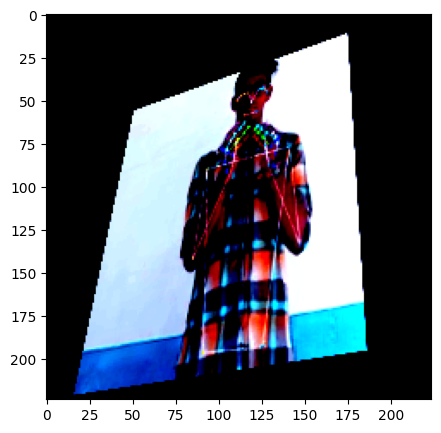

In [ ]:
plt.imshow(inputs['pixel_values'][0,21].cpu().permute(1, 2, 0))

In [ ]:
print(inputs['pixel_values'].min())
print(inputs['pixel_values'].max())

tensor(-1.8606)
tensor(2.6400)


In [ ]:
val_ds = dataset_obj.create_dataset(val_path[:2], val_label[:2], training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

0

In [ ]:
# Example usage
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['head_mask'].shape, inputs['labels'].shape)

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 12]) torch.Size([2, 37])


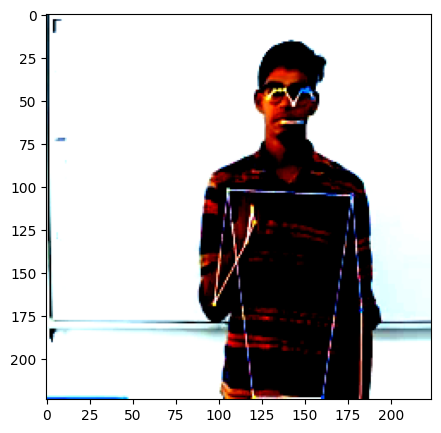

In [ ]:
plt.imshow(inputs['pixel_values'][0,7].cpu().permute(1, 2, 0))

In [ ]:
print(inputs['pixel_values'].min())
print(inputs['pixel_values'].max())

tensor(-2.1179)
tensor(2.6400)


# Creating DataLoader

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
train_ds = dataset_obj.create_dataset(train_path, train_label, training=True)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
del train_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/390 [00:00<?, ?it/s]

17

In [ ]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape) #inputs['head_mask'].shape

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 37])


In [ ]:
val_ds = dataset_obj.create_dataset(val_path, val_label, training=False)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
del val_ds
torch.cuda.empty_cache()
gc.collect()

  0%|          | 0/122 [00:00<?, ?it/s]

17

In [ ]:
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape) #inputs['head_mask'].shape

torch.Size([2, 32, 3, 224, 224]) torch.Size([2, 37])


In [ ]:
#inputs['labels'].type()

In [ ]:
#train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
#val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Model Training

In [ ]:
#config_demo = VideoMAEConfig.from_pretrained(MODEL_TRANSFORMER, id2label=idx_to_label,label2id=label_to_idx, num_labels=len(classes),
#                                             num_frames=CLIP_LENGTH,
#                                             architectures='VideoMAEForVideoClassification',return_dict=True)
#demo_transformer = VideoMAEForVideoClassification.from_pretrained(MODEL_TRANSFORMER, config=config_demo)

In [ ]:
#demo_transformer.config

In [ ]:
#demo_transformer

In [ ]:
#output = demo_transformer(**inputs)

In [ ]:
#output.logits.argmax(1)

tensor([29, 29])

In [ ]:
# Creating NN Layer
#class SignClassificationModel(torch.nn.Module):
#    def __init__(self, model_name, idx_to_label, label_to_idx, classes_len):
#        super(SignClassificationModel, self).__init__()
#        self.config = VideoMAEConfig.from_pretrained(model_name, id2label=idx_to_label,
#                                                     label2id=label_to_idx, hidden_dropout_prob=hyperparameters['dropout_rate'],
#                                                     attention_probs_dropout_prob=hyperparameters['dropout_rate'],
#                                                     num_frames=CLIP_LENGTH,
#                                                     #num_attention_heads=hyperparameters['num_att_heads'],
#                                                     return_dict=True)
#        self.backbone = VideoMAEForVideoClassification.from_pretrained(model_name, config=self.config)  # Load ViT model
#        #self.ff_head = Linear(3137*self.backbone.config.hidden_size, 1)
#        self.ff_head = Linear(self.backbone.config.hidden_size, classes_len)
#        #self.class_head = Linear(1, classes_len) # Convert to classes feature vector
#        #self.relu = ReLU()
#        self.softmax = Softmax(dim=1)
#
#    def forward(self, images):
#        x = self.backbone(images).last_hidden_state #[:, 0]  # Extract embeddings
#        self.backbone.gradient_checkpointing_enable()
#        # Freeze the backbone
#        for param in self.backbone.parameters():
#          param.requires_grad = False
#
#        #x = torch.flatten(x, start_dim=1) # Newly added
#        # Reduce along emb_dimension1 (axis 1)
#        reduced_tensor = x.mean(dim=1)
#        reduced_tensor = self.ff_head(reduced_tensor)
#        #x = self.relu(x)
#        #x = self.class_head(x)  # Convert to number of classes
#        #x = self.softmax(x) # Find Softmax
#        #x = F.softmax(x, dim=1, dtype=torch.float32)
#        return reduced_tensor

In [ ]:
# Initialize TensorBoard writer
#writer = SummaryWriter(log_dir='runs/experiment_1')  # Path to where logs will be saved

# Now we train the model
def training_function(model_transformer):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    #model_transformer = SignClassificationModel(MODEL_TRANSFORMER, idx_to_label, label_to_idx, len(classes))

    # Loss function
    criterion = CrossEntropyLoss()

    # Instantiate optimizer
    optimizer = AdamW(model_transformer.parameters(), lr=hyperparameters["learning_rate"])

    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the prepare method.
    accelerated_model, acclerated_criterion, acclerated_optimizer, acclerated_train_dl, acclerated_val_dl = accelerator.prepare(model_transformer, criterion, optimizer, train_dl, val_dl)

    # Build the training loop
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
      # We only enable the progress bar on the main process to avoid having 8 progress bars.
      progress_bar = tqdm(range(len(acclerated_train_dl)), disable=not accelerator.is_main_process)
      progress_bar.set_description(f"Epoch: {epoch}")
      accelerated_model.train()
      training_loss = []
      for batch in acclerated_train_dl:
          # Forward pass
          train_output = accelerated_model(**batch)
          train_logits = train_output.logits
          #train_softmax = torch.nn.functional.softmax(train_logits, dim=-1)
          #train_preds = train_logits.argmax(-1)

          #train_loss = train_output.loss
          train_labels = batch['labels']
          train_loss = acclerated_criterion(train_logits, train_labels)
          #train_loss = torch.nn.functional.cross_entropy(input=train_preds, target=train_labels)

          # Backward pass
          accelerator.backward(train_loss)

          # Optimize
          acclerated_optimizer.zero_grad()
          acclerated_optimizer.step()

          # We gather the loss from the GPU cores to have them all.
          training_loss.append(accelerator.gather(train_loss[None]))
          progress_bar.set_postfix({'loss': train_loss.item()})
          progress_bar.update(1)

      # Compute average training loss
      training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: learning rate:", scheduler.get_last_lr())
      accelerator.print(f"epoch {epoch}: training loss:", training_loss_final)

      # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
      accelerated_model.eval()
      validation_loss = []

      for batch in acclerated_val_dl:
          with torch.no_grad():
              val_output = accelerated_model(**batch)
              #outputs = accelerated_model(**batch)

          val_logits = val_output.logits
          #val_softmax = torch.nn.functional.softmax(val_logits, dim=-1)
          #val_preds = val_logits.argmax(-1)

          #val_loss = val_output.loss
          val_labels = batch['labels']
          val_loss = acclerated_criterion(val_logits, val_labels)
          #val_loss = torch.nn.functional.cross_entropy(input=val_preds, target=val_labels)

          # We gather the loss from the GPU cores to have them all.
          validation_loss.append(accelerator.gather(val_loss[None]))

      # Compute average validation loss
      validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
      # Use accelerator.print to print only on the main process.
      accelerator.print(f"epoch {epoch}: validation loss:", validation_loss_final)

      # Step the scheduler
      scheduler.step(validation_loss_final)

      # Save model with early stopping
      if validation_loss_final < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = validation_loss_final
          # Save the entire model (including architecture and weights)
          torch.save(accelerated_model, hyperparameters['output_dir_pt'])
          #accelerator.print("Saveing the model")
          accelerated_model.save_pretrained(hyperparameters['output_dir_transformer'])
          continue
      else:
        epochs_no_improve += 1
        # Check early stopping condition
        if epochs_no_improve == hyperparameters["patience"]:
          accelerator.print("Early stopping!")
          break

In [ ]:
# Run the trainer function
training_function(model_transformer)

  0%|          | 0/195 [00:00<?, ?it/s]

epoch 0: learning rate: [0.0001]
epoch 0: training loss: 3.7385667855922993
epoch 0: validation loss: 3.73989218571147


Configuration saved in /content/drive/MyDrive/Kaggle/SignLanguage/timesformer_pytorch_transformer_GPU_1/config.json
Model weights saved in /content/drive/MyDrive/Kaggle/SignLanguage/timesformer_pytorch_transformer_GPU_1/model.safetensors


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0001]
epoch 1: training loss: 3.6863855123519897
epoch 1: validation loss: 3.73989218571147


  0%|          | 0/195 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0001]
epoch 2: training loss: 3.7297711641360554
epoch 2: validation loss: 3.73989218571147


  0%|          | 0/195 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load model

In [ ]:
#model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer']).to(device)
#model_pretrained.eval()
#print("Entire model loaded successfully!")

In [ ]:
#model_pretrained = torch.load(hyperparameters['output_dir'], map_location=torch.device('cpu'))
#model_pretrained.eval()
#print("Entire model loaded successfully!")

# Model Testing - TEST Data

In [ ]:
class CustomDatasetTest(Dataset):
    def __init__(self, pixel_values, labels):
        self.pixel_values = pixel_values.to('cpu')
        self.labels = labels.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx],
            'labels':self.labels[idx]
        }
        return item

In [ ]:
class CreateDatasetTest():
    def __init__(self, clip_length, image_processor, class_len):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor
        self.class_len = class_len

    def create_dataset(self, video_paths, labels):
        pixel_values = []

        for path in tqdm(video_paths):
            # Read and process Videos
            vr = VideoReader(path)
            video = vr.get_batch(list(range(len(vr))))
            video = video[:self.clip_length]

            # Data Preperation for ML Model without Augmentation
            video = transforms.v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)
            video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')

            pixel_values.append(video['pixel_values'].squeeze(0))

            # Force garbage collection
            del vr, video
            gc.collect()

        pixel_values = torch.stack(pixel_values)
        labels = F.one_hot(torch.Tensor(labels).long(), num_classes=self.class_len).type(torch.DoubleTensor)
        labels = labels.clone().detach()

        return CustomDatasetTest(pixel_values=pixel_values,
                                 labels=labels)

In [ ]:
dataset_test_obj = CreateDatasetTest(CLIP_LENGTH, image_processor, len(classes))

In [ ]:
test_ds = dataset_test_obj.create_dataset(test_path, test_label)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)
del test_ds
gc.collect()

  0%|          | 0/98 [00:00<?, ?it/s]

0

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": 42,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/timesformer_pytorch_GPU_1.pt",
    "output_dir_transformer": f"{gdrive_path}/timesformer_pytorch_transformer_GPU_1",
    'dropout_rate': 0.3,
    #'num_dense_layers': 6,
    #'hidden_dim': 16
    #'num_att_heads': 8 #originally 12
}

In [ ]:
# Load the model
#model_pretrained = torch.load(hyperparameters['output_dir_pt'], map_location=torch.device('cpu'), weights_only=False)

In [ ]:
# Now we train the model
def testing_function(model_pretrained):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        test_label = batch['labels']
        test_labels.append(test_label)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_labels, test_preds


In [ ]:
actual_label, predicted_test_label = testing_function(model_transformer)

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')

In [ ]:
predicted_test_labels.numpy()

array([33,  2,  0, 19,  5,  5, 27, 19, 12,  1, 31, 12, 33, 12,  5,  2,  5,
        8,  2, 22,  5, 12,  5, 27,  5,  2, 33, 27,  2, 22, 33, 12, 19, 27,
        8,  8, 12, 33, 22,  8, 33,  8,  3,  8,  8,  5,  5, 30,  8,  8,  8,
        8,  5,  5, 12,  8, 19, 19, 22, 27, 27, 27, 12, 27, 27,  8,  5,  8,
        8, 19, 33,  8,  8, 33,  3, 27, 19, 30, 33,  8,  8,  5,  8, 19, 33,
        0, 33,  8, 19,  2,  8, 12,  8,  8, 27, 19, 27,  3])

In [ ]:
actual_labels_val = actual_labels.argmax(-1)

In [ ]:
actual_labels_val.numpy()

array([27, 29, 27, 31,  5, 25, 30, 14, 13, 26, 31, 18, 36,  7,  8, 29, 21,
       15, 33, 15, 22,  1, 35, 21, 25, 28,  2, 34, 11, 14, 28,  4, 14, 29,
       28, 19,  9, 23, 15, 24, 21, 22, 32,  2, 16, 24, 17,  8, 27, 21, 17,
       35, 31, 15, 10, 23, 36, 34, 30, 19, 17, 35,  3,  0, 27,  5, 28, 11,
       19,  8, 23, 17, 33, 25,  6, 16,  8, 11,  0,  2, 34, 24, 34, 36,  0,
       30, 33, 14,  5, 33, 23, 20, 30, 22,  2,  0, 16, 12])

In [ ]:
print(classification_report(actual_labels_val.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.08      0.33      0.12         3
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Create MP Objects

In [ ]:
hand_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/hand_landmarker.task'
pose_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/pose_landmarker.task'

In [ ]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
#FaceLandmarker = mp.tasks.vision.FaceLandmarker
#FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options_hand = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path = hand_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a pose landmarker instance with the video mode:
options_pose = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

## Create a face landmarker instance with the video mode:
#options_face = FaceLandmarkerOptions(
#    base_options=BaseOptions(model_asset_path=face_model_path),
#    running_mode=VisionRunningMode.VIDEO)

#detector_face = vision.FaceLandmarker.create_from_options(options_face)
detector_hand = vision.HandLandmarker.create_from_options(options_hand)
detector_pose = vision.PoseLandmarker.create_from_options(options_pose)

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

# Model testing - PROD Data

In [ ]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx]
        }
        return item

In [ ]:
class CreateDatasetProd():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a sample transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:

            #Convert pytorch Tensor to CV2 image
            image = frame.permute(1, 2, 0).numpy() # Convert to (H, W, C) format for mediapipe to work

            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            annotated_image.append(torch.from_numpy(image))

            del image, results
            # Force garbage collection
            gc.collect()

        return torch.stack(annotated_image)

    def create_dataset(self, video_paths):
        pixel_values = []
        for path in tqdm(video_paths):
            #print('Video', path)
            # Read and process Videos
            video = self.read_video(path)
            #print('Stage 1',video.shape)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*2, self.clip_size*3)) # Auto converts to (F, C, H, W) format
            #print('Stage 2',video.shape)
            video = self.add_landmarks(video)
            #print('Stage 3',video.shape)
            # Data Preperation for ML Model without Augmentation
            video = self.transform_prod(video.permute(0, 3, 1, 2))

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        return CustomDatasetProd(pixel_values=pixel_values)


In [ ]:
dataset_prod_obj = CreateDatasetProd(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS)

In [ ]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

In [ ]:
# Collect all video files
prod_video_path = []

prod_video_file = glob(os.path.join(prod_data_dir, '*.mov'))
print(prod_video_file)
prod_video_path.extend(prod_video_file)

In [ ]:
print('input path size:', len(prod_video_path))
print(prod_video_path)

In [ ]:
prod_ds = dataset_prod_obj.create_dataset(prod_video_path)

In [ ]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [ ]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

In [ ]:
sample_video = prod_inputs['pixel_values'][0].permute(0, 2, 3, 1)
sample_video.shape

In [ ]:
plt.imshow(sample_video[15])

In [ ]:
# Now we train the model
def prod_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_prod_dl = accelerator.prepare(model_pretrained, prod_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_preds = []

    for batch in tqdm(acclerated_prod_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_preds


In [ ]:
predicted_label = prod_function()

In [ ]:
predicted_label

In [ ]:
predicted_prod_labels = torch.cat(predicted_label,0).to('cpu')

In [ ]:
for val in predicted_prod_labels:
  print(idx_to_label[val.item()])

In [ ]:
for path in prod_video_path:
  print(os.path.basename(path).split('/')[-1])

In [ ]:
idx_to_label

In [ ]:
#print(classification_report(test_label,predicted_label))